# CS 429: Information Retrieval
<br>

## Expectation Maximization for Clustering

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology
### Spring 2015

Last time:

**K-Means** Algorithm Overview

1. Pick $K$ mean vectors at random
2. Iterate until convergence:
  1. Assign each document $x_i$ to its closest mean vector $\mu_j$
  2. Update each mean vector $\mu_j$ to be the mean of the $x_i$'s assigned to it
  
**K-means objective**

- Let $M = \{\mu_1 \ldots \mu_K\}$ be the set of mean vectors.
- Let $r_{ij} = 1$ if $x_i$ belongs to cluster $j$, otherwise 0.

$$E(D, M) = \sum_{i=1}^N \sum_{j=1}^K r_{ij} d(x_i, \mu_j)$$

= "sum of distances from each document to its assigned cluster center."

So, optimal clustering is:

$$M^* \leftarrow \mathop{\rm argmin}_M E(D, M)$$

**Problems with K-Means:**
- **Outliers:** Points far from centroids can result in poorly positioned mean vectors
- **Non-circular data:** Clusters have higher variances in some dimensions than others. This should be reflected in distance measure.

To address these issues, we next turn to a method that:
- Weights points by distance from $\mu$ when recomputing the average
- Allows clusters that are ellipses, rather than circles.

Rather than using a single point ($\mu$) to represent the cluster, use a $V-$dimensional Gaussian.

1-dimensional Gaussian:

$$N(x, \mu, \sigma^2) = \frac{1}{\sigma \sqrt{2\pi}}e^{\frac{-(\mu-x)^2}{2\sigma^2}}\propto e^{\frac{-(\mu-x)^2}{2\sigma^2}}$$

![normal](images/normal.png)
[source](https://en.wikipedia.org/wiki/Normal_distribution)


In V-dimensions:

$$N(x, \mu, \sigma) \propto e^{-(\frac{(x_1 - \mu_1)^2}{2 \sigma_1^2} + \ldots + \frac{(x_V - \mu_V)^2}{2 \sigma_V^2})}$$

E.g., in two dimensions:

![bivariate](images/bivariate.png)
[source](http://dnene.bitbucket.org/docs/mlclass-notes/lecture16.html)

By modeling cases where variance differs by dimension ($\sigma_i \ne \sigma_j$), we can capture clusters like this:

![unequal_var](images/unequal_var.jpg)
[source](http://www.mathworks.com/matlabcentral/fileexchange/46324-gaussian-ellipses-constant-probability-curves)

**Expectation Maximization Algorithm (EM)**

1. Pick $\mu$, $\sigma$ randomly (or cleverly)
2. Iterate until convergence:
  1. **E-step (Expectation):** $$p(r_{ij} | x_i) = N(x_i, \mu_j, \sigma_j)$$ Compute distribution over possible clusters for each data point. (Recall that $r_{ij}$ is 1 if instance $i$ is assigned to cluster $j$, and 0 otherwise.)
  2. **M-step (Maximization):** $$\mu_j = \frac{\sum_i p(r_{ij} | x_i)x_i}{\sum_i p(r_{ij}|x_i)}$$
  Recompute mean as weighted average over all points.
  $$ \sigma_j = \frac{\sum_i p(r_{ij}) (x_i - \mu_j)(x_i - \mu_j)^T}{\sum_i p(r_{ij} | x_i)}$$
  Recompute variance as weighted average over all points.
  
Typically, for high-dimensional problems, we ignore the off-diagonal terms of the covariance matrix (i.e., $\sigma_{jk}$)
  

Below, we use expectation maximization to find the means of two clusters for two-dimensional data.

We assume diagonal covariance matrices.

The bivariate normal density in this case is:

$\begin{align}
N(\vec{\mu}, \vec{\sigma}, \vec{x}) = \frac{1}{2\pi\sigma_1\sigma_2}
\exp\left(- \frac{(x_1-\mu_1)^2}{2\sigma_1^2} + \frac{(x_2-\mu_2)^2}{2\sigma_2^2}\right)
\end{align}
$

Let $\vec{\mu^j}, \vec{\sigma^j}$ be the mean and variance for cluster $j$. We update at each iteration with:


$\begin{align}
\mu_j' = \frac{\sum_i N(\vec{\mu^j}, \vec{\sigma^j}, \vec{x_i})\vec{x_i}}{\sum_i N(\vec{\mu^j}, \vec{\sigma^j}, \vec{x_i})}
\end{align}
$


Populating the interactive namespace from numpy and matplotlib


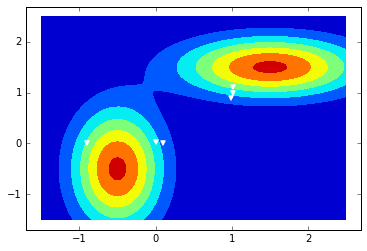

In [20]:
% pylab inline
import numpy as np
from numpy import array as npa

def gauss(mean, covar, x):
    """
    Bivariate Gaussian distribution, assuming diagonal covariance.
    1/(2*pi*v1*v2) * exp(- 1/2 * (x1-mean1)**2/v1 + (x2-mean2)**2/v2)
    """
    Xmu = x[0]-mean[0]
    Ymu = x[1]-mean[1]
    z = Xmu**2 / (covar[0]**2) + Ymu**2 / (covar[1]**2)
    denom = 2 * np.pi * covar[0] * covar[1]
    return np.exp(-z / 2.) / denom

data = np.array([npa([0.,0.02]), npa([.1,0.005]), 
                 npa([-0.9,.01]),
                 npa([1.01,1.]), npa([.99,0.9]), 
                 npa([1.02,1.1])])

mean1 = npa([-.5, -.5])
covar1 = npa([.4, .8])
mean2 = npa([1.5, 1.5])
covar2 = npa([.8, .4])

def plotme(mean1, covar1, mean2, covar2, data):
    x, y = np.mgrid[-1.5:2.5:.01, -1.5:2.5:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    contourf(x, y,
             [gauss(mean1, covar1, [xi, yi]) + gauss(mean2, covar2, [xi, yi])
              for (xi, yi) in zip(x, y)])
    scatter([d[0] for d in data], [d[1] for d in data], marker='v', color='w')

plotme(mean1, covar1, mean2, covar2, data)


new mean1= [-0.37173459  0.01202256] 
new mean2= [ 1.01010548  1.02306542]
difference in means= 1.60711708078


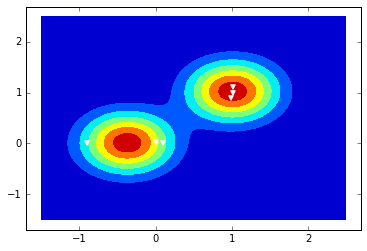

In [10]:
def e_step(data, mean1, covar1, mean2, covar2):
    return[(gauss(mean1, covar1, point), 
            gauss(mean2, covar2, point))
          for point in data]

def m_step(data, mean1, covar1, mean2, covar2, probs):
    # Here, we're only updating means.
    new_mean1 = npa([0., 0.])
    new_mean2 = npa([0., 0.])
    for point, prob in zip(data, probs):
        new_mean1 += prob[0] * point
        new_mean2 += prob[1] * point
    new_mean1 /= sum(p[0] for p in probs)
    new_mean2 /= sum(p[1] for p in probs)
    return new_mean1, new_mean2

def iterate(data, mean1, covar1, mean2, covar2):
    probs = e_step(data, mean1, covar1, mean2, covar2)
    new_mean1, new_mean2 = m_step(data, mean1, covar1, mean2, covar2, probs)
    print('new mean1=', new_mean1, '\nnew mean2=', new_mean2)
    print('difference in means=', 
          np.sum(np.abs(new_mean1 - mean1) + 
                 np.abs(new_mean2 - mean2)))
    plotme(new_mean1, covar1, new_mean2, covar2, data)
    return new_mean1, new_mean2

mean1, mean2 = iterate(data, mean1, covar1, mean2, covar2)

new mean1= [-0.20807764  0.01281648] 
new mean2= [ 1.00533049  0.99938949]
difference in means= 0.192901774886


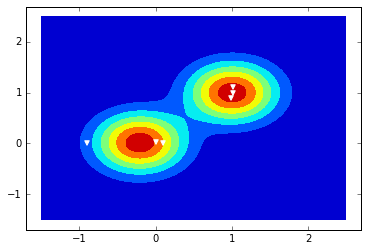

In [11]:
mean1, mean2 = iterate(data, mean1, covar1, mean2, covar2)

new mean1= [-0.06819574  0.01356879] 
new mean2= [ 1.00489053  0.99808265]
difference in means= 0.142381021534


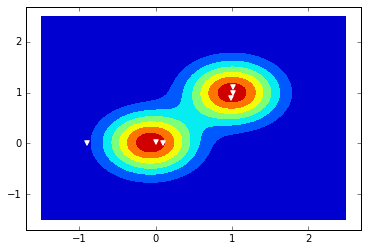

In [12]:
mean1, mean2 = iterate(data, mean1, covar1, mean2, covar2)

new mean1= [-0.00374725  0.01470823] 
new mean2= [ 1.00486266  0.99800587]
difference in means= 0.0656925689312


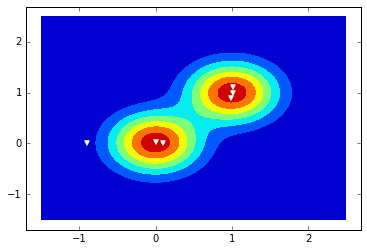

In [13]:
mean1, mean2 = iterate(data, mean1, covar1, mean2, covar2)

new mean1= [-0.36962137  0.0124808 ] 
new mean2= [ 1.00946055  1.02064844]
difference in means= 1.6127504413
new mean1= [-0.20311972  0.0149243 ] 
new mean2= [ 0.99227608  0.98658457]
difference in means= 0.220193491054
new mean1= [-0.05765685  0.0204122 ] 
new mean2= [ 0.98821244  0.98142437]
difference in means= 0.160174602874
new mean1= [ 0.01765206  0.03223879] 
new mean2= [ 0.98747026  0.98052089]
difference in means= 0.0887811551937
new mean1= [ 0.04827439  0.04406639] 
new mean2= [ 0.98733662  0.98035918]
difference in means= 0.0427452888914
new mean1= [ 0.06095554  0.05098219] 
new mean2= [ 0.98731259  0.98033013]
difference in means= 0.0196500434718
new mean1= [ 0.06646637  0.05437019] 
new mean2= [ 0.98730827  0.98032491]
difference in means= 0.00890836798046
new mean1= [ 0.06892658  0.05595287] 
new mean2= [ 0.98730749  0.98032397]
difference in means= 0.00404460081329
new mean1= [ 0.07003892  0.05668201] 
new mean2= [ 0.98730735  0.9803238 ]
difference in means= 0.001841784

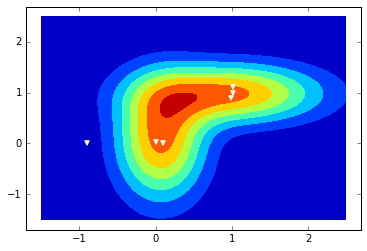

In [21]:
for i in range(10):
    mean1, mean2 = iterate(data, mean1, covar1, mean2, covar2)

In [16]:
data

array([[ 0.   ,  0.02 ],
       [ 0.1  ,  0.005],
       [-0.9  ,  0.01 ],
       [ 1.01 ,  1.   ],
       [ 0.99 ,  0.9  ],
       [ 1.02 ,  1.1  ]])

In [22]:
e_step(data, mean1, covar1, mean2, covar2)

[(0.48916030159118573, 0.013011401445573289),
 (0.49496516618436076, 0.013756986426530534),
 (0.026153142188780811, 0.0016230057728347156),
 (0.015745591683459646, 0.49655801695642854),
 (0.020333525676900669, 0.48742899093874786),
 (0.012709862692887187, 0.47519249990336104)]

Note how outlier does not affect mean very much.